<a href="https://colab.research.google.com/github/suchithreddy02/Skin-Cancer-Detection/blob/main/Skin_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:35<00:00, 212MB/s]
100% 5.20G/5.20G [00:35<00:00, 159MB/s]


In [ ]:
! unzip skin-cancer-mnist-ham10000

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/HAM10000_images_part_2/ISIC_0030573.jpg
/content/HAM10000_images_part_2/ISIC_0029903.jpg
/content/HAM10000_images_part_2/ISIC_0031254.jpg
/content/HAM10000_images_part_2/ISIC_0030730.jpg
/content/HAM10000_images_part_2/ISIC_0032456.jpg
/content/HAM10000_images_part_2/ISIC_0033737.jpg
/content/HAM10000_images_part_2/ISIC_0032615.jpg
/content/HAM10000_images_part_2/ISIC_0032792.jpg
/content/HAM10000_images_part_2/ISIC_0032835.jpg
/content/HAM10000_images_part_2/ISIC_0032218.jpg
/content/HAM10000_images_part_2/ISIC_0032256.jpg
/content/HAM10000_images_part_2/ISIC_0033130.jpg
/content/HAM10000_images_part_2/ISIC_0032078.jpg
/content/HAM10000_images_part_2/ISIC_0029924.jpg
/content/HAM10000_images_part_2/ISIC_0033111.jpg
/content/HAM10000_images_part_2/ISIC_0029826.jpg
/content/HAM10000_images_part_2/ISIC_0030252.jpg
/content/HAM10000_images_part_2/ISIC_0030207.jpg
/content/HAM10000_images_part_2/ISIC_0030620.jpg
/content/HAM10000_

In [ ]:
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from cv2 import imread, resize # manipulating the images
from tensorflow.keras.optimizers import Adam
import os

In [ ]:
df = pd.read_csv("/content/HAM10000_metadata.csv")
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

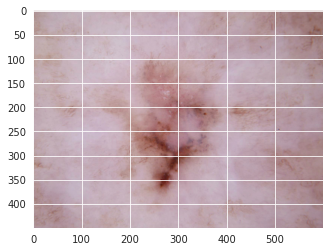

In [ ]:
from PIL import Image
img = Image.open('/content/HAM10000_images_part_2/ISIC_0029315.jpg')
plt.imshow(img)

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

In [ ]:
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Maping the lesion type and ID to a dict.
df['lesion_type']=df['dx'].map(lesion_type_dict)
df['lesion_ID'] = df['dx'].map(lesion_ID_dict)

# Display the total found images.
print('Total number of images', len(df))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


In [ ]:
df['lesion_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

In [ ]:
fname_images = np.array(df['image_id'])
file_to_read ='/content/HAM10000_images_part_1/'+str(fname_images[13])+'.jpg'
print(file_to_read)

/content/HAM10000_images_part_1/ISIC_0025767.jpg


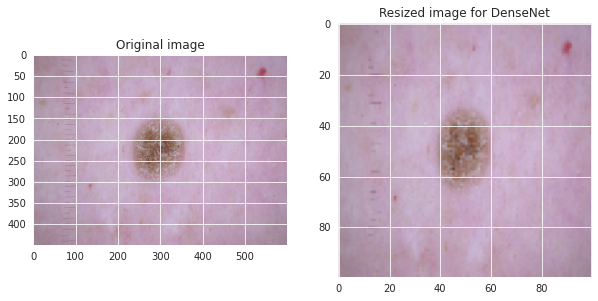

In [ ]:
img = cv2.imread(file_to_read)
img2 = cv2.resize(img, (100, 100))

# Show one exampe image before and after
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Resized image for DenseNet')
plt.show()


In [ ]:
def produce_new_img(img2: cv2) -> tuple:
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)
    imge = cv2.flip(img2, 1)
    new_imges = imga, imgb, imgc, imgd ,imge
    return new_imges

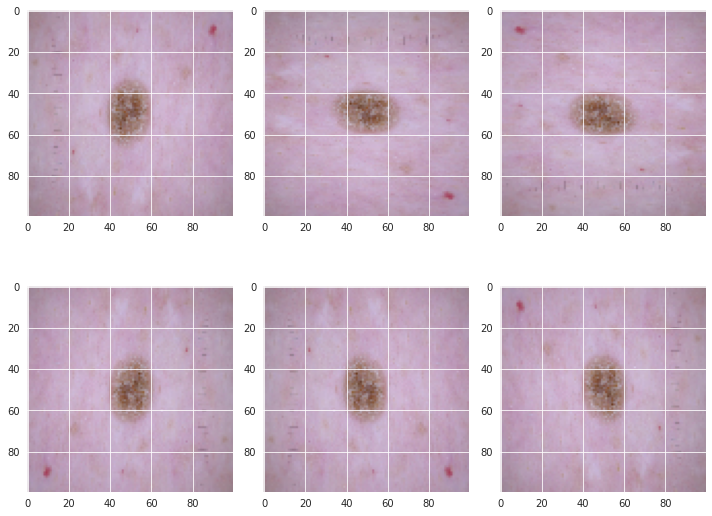

In [ ]:
def show_example():
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img2[:, :, ::-1])
    for i in range(5):
        plt.subplot(2, 3, 2+i)
        plt.imshow(new_img[i][:, :, ::-1])
    plt.tight_layout()
    plt.show()
new_img = produce_new_img(img2)

show_example()

In [ ]:
x = []
y = []

lista1 = os.listdir('/content/HAM10000_images_part_1/')
lista2 = os.listdir('/content/HAM10000_images_part_2')

for i in range(len(lista1)):
    
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/HAM10000_images_part_1/' + str(fname_image) 
    img = imread(file_to_read)                                  
    img2 = resize(img,(100, 100))                               
    x.append(img2)
    output = np.array(df[df['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    if i % 100 == 0:
        print(i, 'images loaded')
for i in range(len(lista2)):

    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/HAM10000_images_part_2/' + str(fname_image)


    img = imread(file_to_read)
    img2 = resize(img, (100, 100))
    x.append(img2)
   
    output = np.array(df[df['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
   
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    
    if i % 100 == 0:
        print(len(lista1) + i,'images loaded')

0 images loaded
100 images loaded
200 images loaded
800 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1600 images loaded
1700 images loaded
1800 images loaded
1900 images loaded
2100 images loaded
2200 images loaded
2300 images loaded
2500 images loaded
2700 images loaded
2800 images loaded
2900 images loaded
3000 images loaded
3100 images loaded
3200 images loaded
3300 images loaded
3400 images loaded
3500 images loaded
3600 images loaded
3800 images loaded
3900 images loaded
4000 images loaded
4100 images loaded
4200 images loaded
4300 images loaded
4400 images loaded
4500 images loaded
4600 images loaded
4800 images loaded
4900 images loaded
5000 images loaded
5200 images loaded
5300 images loaded
5400 images loaded
5800 images loaded
5900 images loaded
6000 images loaded
6400 images loaded
6500 images loaded
6600 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7000 images loaded
7100 images loaded
7200 images loaded
7300 images loaded

In [ ]:
x = np.array(x)
y = np.array(y)

y_train = to_categorical(y, num_classes = 7)

X_train, X_test, y_train, y_test = train_test_split(x,                  
                                                    y_train,            
                                                    test_size = 0.20,   
                                                    random_state = 50,  
                                                    stratify = y)       

print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (21252, 100, 100, 3)
Test dataset shape (5313, 100, 100, 3)


In [ ]:
def est_class_weights(dis_id: np.array) -> dict:
    
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))

y_id = np.array(df['lesion_ID'])
new_class_weights = est_class_weights(y_id)
print(new_class_weights)

None


In [ ]:
model = Sequential()
        

model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="valid"))
model.add(BatchNormalization())


model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())


model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten()) 

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              
model.add(Dense(7, activation = 'softmax'))

In [ ]:
def mod_checkpoint_callback() -> None:
    
    trained_model = ModelCheckpoint(filepath = 'model.h5',  
                             save_weights_only = False,     
                             monitor = 'val_accuracy',      
                             mode = 'auto',                 
                             save_best_only = True,     
                             verbose = 1)
    return trained_model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 35, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()


optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip = True, shear_range = 0.3)
datagen.fit(X_train)

batch_size = 32
epochs = 35


history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )

Epoch 1/35
665/665 [==============================] - ETA: 0s - loss: 1.2658 - accuracy: 0.5147
Epoch 1: val_accuracy improved from -inf to 0.39507, saving model to model.h5
665/665 [==============================] - 563s 844ms/step - loss: 1.2658 - accuracy: 0.5147 - val_loss: 1.5194 - val_accuracy: 0.3951
Epoch 2/35
665/665 [==============================] - ETA: 0s - loss: 1.0565 - accuracy: 0.5865
Epoch 2: val_accuracy improved from 0.39507 to 0.53604, saving model to model.h5
665/665 [==============================] - 558s 839ms/step - loss: 1.0565 - accuracy: 0.5865 - val_loss: 1.1917 - val_accuracy: 0.5360
Epoch 3/35
665/665 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.6176
Epoch 3: val_accuracy improved from 0.53604 to 0.62620, saving model to model.h5
665/665 [==============================] - 559s 840ms/step - loss: 0.9789 - accuracy: 0.6176 - val_loss: 0.9660 - val_accuracy: 0.6262
Epoch 4/35
665/665 [==============================] - ETA: 0s - los

In [ ]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 29s 174ms/step - loss: 1.3629 - accuracy: 0.6759
Accuracy: 67.59%
